# Preparação do ambiente
Vamos aqui importar as bibliotecas e o dataset.
Os dois modelos escolhidos foram: Naive-bayes; MLP-Classification.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Processamento de dados
from sklearn.preprocessing import LabelEncoder


# Pipeline e vetorização (e crossvalidation)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# MLP, Classifier
from sklearn.neural_network import MLPClassifier


# Avaliação

from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix



In [73]:
df = pd.read_csv('checkpoint3.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,spam,NaN,NaN,NaN,NaN
1,spam,NaN,NaN,NaN,NaN
2,ham,NaN,NaN,NaN,NaN
3,ham,NaN,NaN,NaN,NaN
4,ham,NaN,NaN,NaN,NaN


# Entendimento dos dados

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8358 entries, 0 to 8357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          8358 non-null   object
 1   v2          8336 non-null   object
 2   Unnamed: 2  83 non-null     object
 3   Unnamed: 3  22 non-null     object
 4   Unnamed: 4  9 non-null      object
dtypes: object(5)
memory usage: 326.6+ KB


A maioria das colunas extras são NaN. Provavelmente ocorre devido ao text não ser salvo entre aspas. Podemos remover. Esperamos em torno de 8336 valores válidos.

# Processamento de dados

In [ ]:
df_col_renamed = df.copy()
df_col_renamed.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
df_col_renamed['label'] = LabelEncoder().fit_transform(df_col_renamed['label'])
df_col_renamed.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN


In [21]:
df_text_columns = ['text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

In [22]:
df_merged = df_col_renamed.copy()
df_merged['merged'] = df_col_renamed[df_text_columns].agg(lambda x: ' '.join(x.dropna()) if x.notna().any() else pd.NA, axis=1)
df_merged 

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,merged
0,1,NaN,NaN,NaN,NaN,<NA>
1,1,NaN,NaN,NaN,NaN,<NA>
2,0,NaN,NaN,NaN,NaN,<NA>
3,0,NaN,NaN,NaN,NaN,<NA>
4,0,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...
8353,1,pdate_Now - Double mins and 1000 txts on Orang...,NaN,NaN,NaN,pdate_Now - Double mins and 1000 txts on Orang...
8354,0,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t...",NaN,NaN,NaN,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t..."
8355,0,Hey what's up charles sorry about the late reply.,NaN,NaN,NaN,Hey what's up charles sorry about the late reply.
8356,0,Oh oh... Den muz change plan liao... Go back h...,NaN,NaN,NaN,Oh oh... Den muz change plan liao... Go back h...


In [23]:
df_na_dropped = df_merged.dropna(subset=['merged'])
df_na_dropped = df_na_dropped.dropna(axis=1)
df_na_dropped

,label,merged
11,0,"I wake up long ago already... Dunno, what othe..."
12,0,K...k...when will you give treat?
13,1,Think ur smart ? Win å£200 this week in our we...
14,1,URGENT! We are trying to contact U. Todays dra...
15,1,PRIVATE! Your 2003 Account Statement for 07808...
...,...,...
8353,1,pdate_Now - Double mins and 1000 txts on Orang...
8354,0,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t..."
8355,0,Hey what's up charles sorry about the late reply.
8356,0,Oh oh... Den muz change plan liao... Go back h...


# Modelagem
Já fazer a pipeline!

Agora é necessário vetorizar os textos. Vamos já deixar na pipeline

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df_na_dropped['merged'], df_na_dropped['label'], test_size=0.2, random_state=42)

Vou usar um random kshuffle pra cv

In [31]:
from sklearn.model_selection import cross_val_score, KFold

In [32]:
cv = KFold(n_splits=5, shuffle=True, random_state=42) # Não acho que seja necessário outro shuffle, já fizemos isso no train_test_split
# Mas não deve afetar o resultado.

## Naive_Bayes

In [28]:
pipeline_naive_bayes = make_pipeline( TfidfVectorizer(), MultinomialNB() )
pipeline_naive_bayes


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
param_grid_naive_bayes = { # Eu reduzi o número de parâmetros porque no MLP já estáva demorando muito.
    'tfidfvectorizer__max_df': [0.9, 1, 3, 5],
    'tfidfvectorizer__min_df': [0.5, 1],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]}

grid_search_naive_bayes = GridSearchCV(pipeline_naive_bayes, param_grid_naive_bayes,
                                        cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

In [47]:
grid_search_naive_bayes.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/hom

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0],
                         'tfidfvectorizer__max_df': [1.1, 3, 5],
                         'tfidfvectorizer__min_df': [0.5, 1],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

Não entendi o erro, mas seguimos pra frente.

O erro provavelmente ocorre devido ao 

## MLP

In [50]:
pipeline_mlp = make_pipeline( TfidfVectorizer(), MLPClassifier(max_iter=350,
                                                                early_stopping=True) ) # Para não gastar tempo demais
pipeline_mlp

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, max_iter=350))])

Treinamento abaixo:

In [37]:
pipeline_mlp.get_params()['steps']

[('tfidfvectorizer', TfidfVectorizer()), ('mlpclassifier', MLPClassifier())]

In [ ]:
param_grid_mlp = { # Reduzido número de parâmetros para não demorar tanto.
    'tfidfvectorizer__max_df': [0.9, 1, 5],
    'tfidfvectorizer__min_df': [0.5, 1, 2],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50)]   
}

grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

In [52]:
grid_search_mlp.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jdpjnfs/Documents/curso/Tarefa aula 6/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/hom

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('mlpclassifier',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=350))]),
             n_jobs=-1,
             param_grid={'mlpclassifier__hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50)],
                         'tfidfvectorizer__max_df': [1.1, 5],
                         'tfidfvectorizer__min_df': [0.5, 1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

Entendi, o erro ocorre pois max_df é porcentagem quando <1 e int quando maior. Então nosso 1.1 estava dando problema. 1 * 3 * 2 * 4 = 24 combinações * 5 = 120 erros.
Erro corrigido.
Como a performance já está boa (98.5%), os erros serão ignorados.

# Avaliação

## NB

In [59]:
y_pred_nb = grid_search_naive_bayes.predict(x_test)

print("Melhores parâmetros para Naive Bayes:", grid_search_naive_bayes.best_params_)
print("Acurácia do Naive Bayes:", accuracy_score(y_test, y_pred_nb))


Melhores parâmetros para Naive Bayes: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 5, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
Acurácia do Naive Bayes: 0.9850119904076738


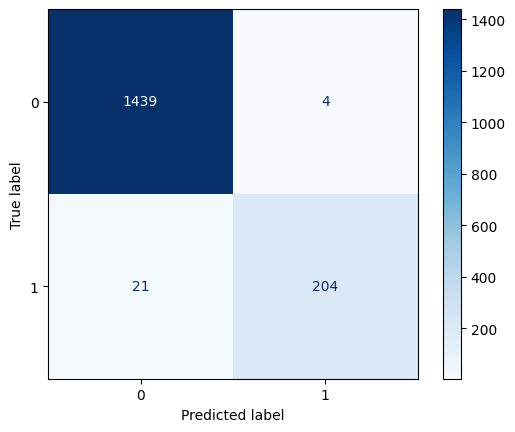

In [56]:

cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_nb_display = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=grid_search_naive_bayes.classes_)
cm_nb_display.plot(cmap=plt.cm.Blues)
plt.show()

## MLP

In [57]:
# Avaliação do modelo MLP
y_pred_mlp = grid_search_mlp.predict(x_test)

print("Melhores parâmetros para MLP:", grid_search_mlp.best_params_)
print("Acurácia do MLP:", accuracy_score(y_test, y_pred_mlp))



Melhores parâmetros para MLP: {'mlpclassifier__hidden_layer_sizes': (50, 50), 'tfidfvectorizer__max_df': 5, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
Acurácia do MLP: 0.9760191846522782


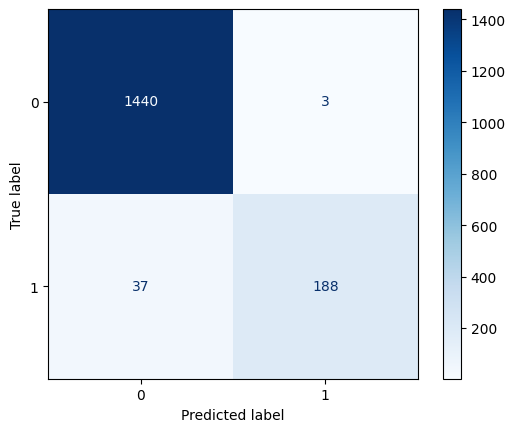

In [60]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
mlp_cmdisplay = ConfusionMatrixDisplay(confusion_matrix = cm_mlp, display_labels = grid_search_mlp.classes_)
mlp_cmdisplay.plot(cmap=plt.cm.Blues)
plt.show()

Como a acurácia do naive-bayes é maior, ele é o melhor modelo.
E seus parâmetros são:

In [68]:
grid_search_naive_bayes.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer(max_df=5, ngram_range=(1, 2))),
  ('multinomialnb', MultinomialNB(alpha=0.1))],
 'transform_input': None,
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_df=5, ngram_range=(1, 2)),
 'multinomialnb': MultinomialNB(alpha=0.1),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 5,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b'

### Explicação dos parâmetros

Os melhores parâmetros foram:
```
'tfidfvectorizer': TfidfVectorizer(max_df=5, ngram_range=(1, 2)),
 'multinomialnb': MultinomialNB(alpha=0.1),
```

max_df = 5 significa que todos termos que aparecem mais de 5 vezes no documento (max document frequency = 5)

(Esta opção está oculta, pois ela é igual ao padrão do modelo)
min_df = 1 (este é o valor padrão do modelo), significa que todos termos que aparecem menos que 1 vez(ou seja, 0) no documento são ignorados


ngram_range(1,2 ) significa que só consideram unigramas e bigramas (n-gram é uma sequência de termos (como usamos a configuração padrão, é palavras)). Ou seja, os unigramas seriam palavras únicas ["Seriam", "palavras, "únicas"] e bigramas duas palavras ("seriam palavras", "palavras únicas")

alpha=0.1 indica o _smoothing parameter_,  uma probabilidade mínima pra uma classe nunca previamente vista, na fórmula P(palavra | classe). No nosso caso, 10%.

## Exportação

In [63]:
# Esqueci de importar pickle
import pickle as pickle

In [65]:
with open('spam_detect_nb.pkl', 'wb') as f:
    pickle.dump(grid_search_naive_bayes, f)